#  3D Mohr Plots and Slip Tendency Analysis

## 3D Mohr plots

The ratio of shear ($\tau$) to normal stress ($\sigma_n$) resolved onto a fracture can be represented using [3D Mohr circles](https://en.wikipedia.org/wiki/Mohr%27s_circle). 

When used by borehole image analysts, the Mohr plot is normalised to vertical stress or effective vertical stress so data from a range of depths can be plotted together. 

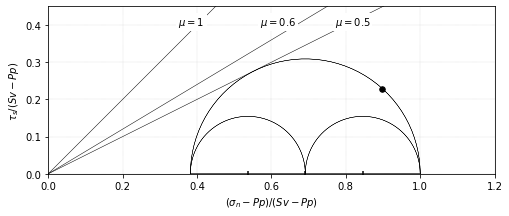

In [9]:
from matplotlib import pyplot as plt
import numpy as np
import math
import pandas as pd
import mplstereonet

import functions as fun

pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 100) 

# Synthetic data for play example
# -------------------------------

fracture = {
    'ID': [1],
    'mVD': [2000],
    'dip': [25],
    'strike': [50],
    'Pp': [16.41],
    'Sv': [39.20],
    'Shmin': [25.12],
    'SHmax': [32.16], # 32.16, 38
}

dffracs = pd.DataFrame(data=fracture)

# append stress field orientation and make a tuple for Sn Tau calculation
# -----------------------------------------------------------------------
''' 
Geographic coordinates are X North, Y East, and Z Down.
Input Euler angles alpha, beta, gamma in degrees
Defining the stress field in Euler angles...
If S1 is vertical (normal faulting) then:
    alpha = the trend of SHmax - pi/2 (aka the azumuth in degrees minus 90 degrees)
    beta = the -ve trend of Sv (aka -90 for vertical stress)
    gamma = 0.
If S1 is horizontal (strike slip or reverse faulting) then:
    alpha = trend of S1
    beta = -ve plunge of S1
    gamma = rake of S2
'''
# beta: -90 is the original and -60 is the (ie 30 deg tilted) for the case study
for df in [dffracs]:
    df['alpha'] = -60 
    df['beta'] = -90 
    df['gamma'] = 0 
    df['Sv_eff'] = df.Sv - df.Pp
    df['SHmax_eff'] = df.SHmax - df.Pp
    df['Shmin_eff'] = df.Shmin - df.Pp 
    # make tuple for fracture_sn_tau(S1,S2,S3,Pp,Norm,alpha,beta,gamma,strike,dip)
    df['fracture'] = df[['Sv','SHmax','Shmin','Pp','Sv_eff','alpha','beta','gamma','strike','dip']].apply(tuple, axis=1)

# Calculate shear and normal stress magnatude
# -------------------------------------------
for df in [dffracs]:
    dalist = []
    for  S1,S2,S3,Pp,Sv,alpha,beta,gamma,strike,dip in df['fracture']:
        dalist.append(fun.fracture_sn_tau(S1,S2,S3,Pp,Sv,alpha,beta,gamma,strike,dip))
    df['Sn_tau'] = pd.Series(dalist).values

# Calculate the ratio of shear to normal stres
# --------------------------------------------
for df in [dffracs]:
    dalist = []
    for Sn, tau, in df['Sn_tau']:
        dalist.append(tau/Sn)
    df['ratio'] = pd.Series(dalist).values

# Generate Mohr plot parts
# --------------------------

# Min Sv value (use effective stress)
Sigma1 = dffracs['Sv_eff'].min()

# Min SHmax value
Sigma2 = dffracs['SHmax_eff'].min()

# Min Shmin value
Sigma3 = dffracs['Shmin_eff'].min()

# make the components for the 3D mohr plot
tauS, normS, meanS = fun.mohr3d(Sigma1,Sigma2,Sigma3,Sigma1) 

# Rearrange for plotting
pltpairs = {                        
    "normStauS":
    [(normS[0],tauS[0]),  # sigma1, sigma3 circle
    (normS[1],tauS[1]),   # sigma1, sigma2 circle
    (normS[2],tauS[2])]   # sigma2, sigma3 circle
}

# Make-Mohr=Coulomb failure criterion
# -----------------------------------
# Generate data to make the criterion lines on the plots 
# following the format used in Barton et al 1995

CFCSn = [0,100]

# mu of 0.5
CFCtau_pnt5 = []
for n in CFCSn:
    CFCtau_pnt5.append(0.5 * n)

# mu of 0.6
CFCtau_pnt6 = []
for n in CFCSn:
    CFCtau_pnt6.append(0.6 * n)

# mu of 1
CFCtau_1 = []
for n in CFCSn:
    CFCtau_1.append(1 * n)

# Draw the plot
# -------------
f = plt.figure(figsize=(8,4))
ax1 = f.add_subplot(111)

# plot the coloumb falure criterion
ax1.plot(CFCSn,CFCtau_1,c='k',linewidth=0.5)
ax1.plot(CFCSn,CFCtau_pnt6,c='k',linewidth=0.5)
ax1.plot(CFCSn,CFCtau_pnt5,c='k',linewidth=0.5) 
ax1.text(0.35, 0.4, r'$\mu = 1$', fontsize=10, 
    bbox={'facecolor': 'white','edgecolor':'none', 'pad': 2})
ax1.text(0.57, 0.4, r'$\mu = 0.6$', fontsize=10, 
    bbox={'facecolor': 'white','edgecolor':'none', 'pad': 2})
ax1.text(0.77, 0.4, r'$\mu = 0.5$', fontsize=10, 
    bbox={'facecolor': 'white','edgecolor':'none', 'pad': 2})

# plot the mean stress tick marks
ax1.scatter(meanS,[0,0,0],color='k',marker='|')

# plot the Mohr plot arcs
for normS, tauS in pltpairs['normStauS']:
    ax1.plot(normS,tauS,'k',linewidth=0.4)

# Plot the fractures
for Sn, tau, in dffracs['Sn_tau']:
    ax1.scatter(Sn,tau,s=30,c='k',marker='o')

# Final formatting and output
ax1.set_ylim(0,0.45)
ax1.set_xlim(0,1.2)
ax1.set_aspect('equal')
ax1.grid(linestyle='--', linewidth=0.2)
ax1.set_xlabel(r'$(\sigma_n - Pp)/(Sv-Pp)$')
ax1.set_ylabel(r'$ \tau_s/(Sv-Pp)$')

plt.show() 
#dffracs

In [3]:
dffracs

,ID,mVD,dip,strike,Pp,Sv,Shmin,SHmax,alpha,beta,gamma,Sv_eff,SHmax_eff,Shmin_eff,fracture,Sn_tau,ratio
0,1,2000,60,50,16.41,39.2,25.12,32.16,-60,-90,0,22.79,15.75,8.71,"(39.2, 32.16, 25.12, 16.41, 22.790000000000003, -60.0, -90.0, 0.0, 50.0, 60.0)","(0.5637403541099563, 0.266145361505197)",0.472106


## Calculate Slip Tendency Analysis

Through a series of algebraic stress tensor rotations, the effective stress tensor can be used to determine the shear ($\tau$) and normal stress ($\sigma_n$) resolved onto a plane. 

For those not familiar with greek letters:
- $\tau$ is said _tau_
- $\sigma_n$ is said _sigma n_

Barton et al. (1995) and others have demonstrated that when the ratio of shear to normal stress is high, then there is a greater likelihood that a fracture has recently re-sheared and is therefore open to fluid flow. We established in 1-openhole-logs.ipynb that there are thermally enhanced hoop stresses at the wall of a geothermal borehole. These conditions mean that many more discontinuities are open at the borehole wall than in the reservoir. Calculating the ratio of shear to normal stress on each fracture enables us to identify the population that is likely open to fluid flow in the reservoir. 

Overview of workflow:
- Define the input fracture geometry (strike/dip), geomechanical model, and pore pressure, noting that the orientation of the stress field is described in terms of Euler angles
- Convert the stress tensor to effective stress
- Transform the stress tensor to geographic coordinates using the Euler angles
- Transform the stress tensor into the coordinate system of the fault/fracture plane, and then select the normal stress
- Transform the stress tensor so it is aligned with the fracture rake, and then select the absolute value of shear stress

The rake is defined here as a vector down the fracture plane perpendicular from the strike, such that we assume pure dip-slip. When characterising a fault in the field, a rake is measured from striations on the fault surface that indicate slip sense and may not be purely dip-slip.   
 
The method I use to calculate shear and normal stress is the tensor transformation process outlined by Zoback (2010, pp 156-157).  

## Case study

The slip tendency workflow described above was run for NM-B is a geothermal well in the Taupō Volcanic Zone, New Zealand. The context and methods are described in detail in Wallis et al. (2020 - submitted) and summarised here.



<img src="images/mohr-plots-02.png" alt="Drawing" style="width: 300px;"/>


<img src="images/mohr-plots-01.png" alt="Drawing" style="width: 1000px;"/>


<img src="images/mohr-plots-03.png" alt="Drawing" style="width: 700px;"/>

When plotted by depth and combined with geologic context, the slip tendency modelling reveals that the upper two feedzones are spatially correlated with clusters of fractures that have a high slip tendency. When combined with the apparent stress field rotations, it is likely that these clusters are associated with recent fault rupture. 

A third feedzone is correlated with a volcaniclastic breccia that was revealed by textural analysis of the borehole image log. Cuttings analysis only indicated that this unit was comprised of andesite lava, likely because cuttings are mm scale and the andesite lava clasts are bolder size. Apparent stress tensor rotation around this depth may be associated with either recent faulting or stress anisotropy related to the sedimentary layers. 

The deepest feedzone is extremely small. Because of the pressure difference between a well filled with cool fluid and the hot reservoir, completion testing empathises deep feedzones. It is not unusual for low-magnitude, deep feedzones to contribute minimally or not at all if a well is flowed. For more information on geothermal well test methodologies, refer to Zarrouk and McLean (2019). Analysis of the geologic context of this deep feedzone has yet to reveal a clear mechanism controlling its location.

<img src="images/slip-tendancy-01.png" alt="Drawing" style="width: 900px;"/>

### Other recommended case studies:
There are rarely examples in the literature where this kind of workflow is applied to geothermal wells, and most work is restricted to the Basin and Range province in the US. Nonetheless, recommended further reading includes: 

- Barton et al. (1995) seminal paper that uses low-permeability scientific boreholes outside geothermal reservoirs 
- Davatzes and Hickman (2010) using wells on the edge of Coso Geothermal System
- Hickman et al. (1997) and Hickman et al. (1998) at Dixie Valley Geothermal System

## Citations

Barton, C. A., Zoback, M. D., and Moos, D., 1995, Fluid flow along potentially active faults in crystalline rock: Geology, v. 23, p. 683-686.

Davatzes, N. C., and Hickman, S. H., 2010, Stress, fracture, and fluid-flow analysis using acoustic and eletrical image logs in hot fractured granites of the Coso Geothermal Field, California, U.S.A, in Pöppelreiter, C., García-Carballido, C., and Kraaijveld, M., eds., Dipmeter and Borehole Image Log Technology, p. 159-293.

Hickman, S., Barton, C., Zoback, M., Morin, R., Sass, J., and Benoit, R., 1997, In-situ stress and fracture permeability in a fault-hosted geothermal reservoir at Dixie Valley, Nevada, Geothermal Resources Council Transactions, Volume 21: Burlingame, California, p. 181-189.

Hickman, S., Zoback, M., and Benoit, R., 1998, Tectonic controls on fault-zone permeability in a geothermal reservoir at Dixie Valley, Nevada, Proceedings of the SPE/ISRM Rock Mechanics in Petroleum Engineering Conference, Volume 1, p. 79-83.

Wallis, I.C., Rowland, J. V. and Dempsey, D. E., Allan, G., Sidik, R., Martikno, R., McLean, K., Sihotang, M., Azis, M. and Baroek, M. 2020 (submitted) Approaches to imaging feedzone diversity with case studies from Sumatra, Indonesia, and the Taupō Volcanic Zone, New Zealand. New Zealand Geothermal Workshop: Waitangi, New Zealand.

Zarrouk, S. J., and McLean, K., 2019, Geothermal well test analysis : fundamentals, applications and advanced techniques, London : Academic Press. 2019.

Zoback, M. D., 2010, Reservoir Geomechanics, Cambridge University Press.

In [14]:
%load_ext watermark
print('author:')
%watermark -a "Irene Wallis" -d
print('\n')
print('requirements:')
%watermark -v -p pandas,matplotlib,mplstereonet,seaborn,watermark,fractoolbox 
print('\n')
%watermark -g

author:
Irene Wallis 2020-08-27


requirements:
CPython 3.7.7
IPython 7.15.0

pandas 1.0.5
matplotlib 3.2.2
mplstereonet 0.6.dev0
seaborn 0.10.1
watermark 2.0.2
fractoolbox not installed


Git hash: e9bfeabc03781cbded80b87ac3852d4b3050a974
